This project is based on the bank telemarketing data from https://www.kaggle.com/competitions/playground-series-s5e8. The dataset contains historical records of direct marketing campaigns conducted by a bank. Each record describes a customer's demographic attributes, financial status, and past interaction history with the bank's marketing team.

The target variable y is binary:

* y = 1 -> the customer subscribed to the term deposit product after the marketing contact.

* y = 0 -> the customer did not subscribe.


Our goal is to build a predictive model that can estimate the likelihood of a customer subscribing, allowing the bank to better target marketing efforts and optimize resources.

In [1]:
# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Modeling Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation
from sklearn.metrics import classification_report, roc_auc_score

# Save
from joblib import dump
import json, sys, sklearn, lightgbm, xgboost
from datetime import datetime

In [2]:
# Load the dataset
bank = pd.read_csv('train.csv')
bank.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [3]:
bank.shape

(750000, 18)

In [4]:
bank = bank.drop(columns=['id']) # id is not useful for prediction

### EDA

In [5]:
bank.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [6]:
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [7]:
bank['y'].value_counts(normalize=True)

y
0    0.879349
1    0.120651
Name: proportion, dtype: float64

In this dataset, only about 12% of contacts resulted in a subscription. Since y is unbalanced, need to pay attention in later modeling. 

In [8]:
categorical_cols = bank.select_dtypes(include='object').columns.tolist()
numerical_cols = bank.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('y')

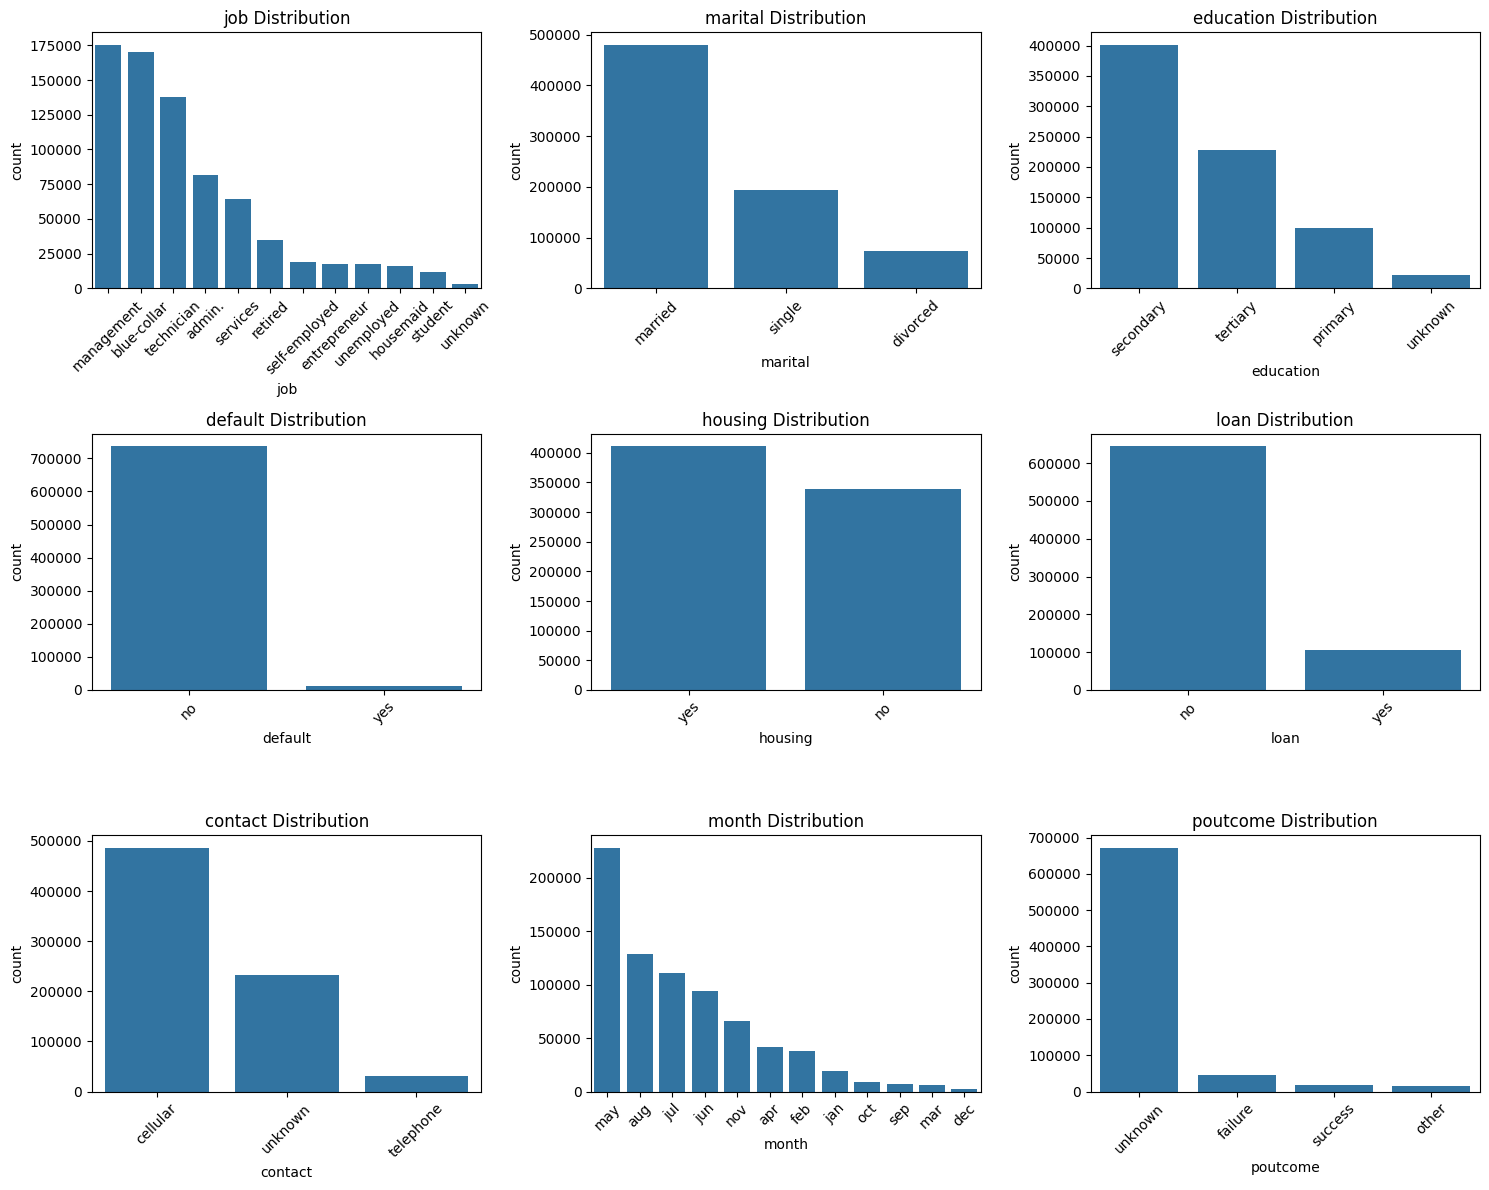

In [9]:
# Visualized the distribution of categorical features in the training set
n_cols = 3
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=bank, order=bank[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

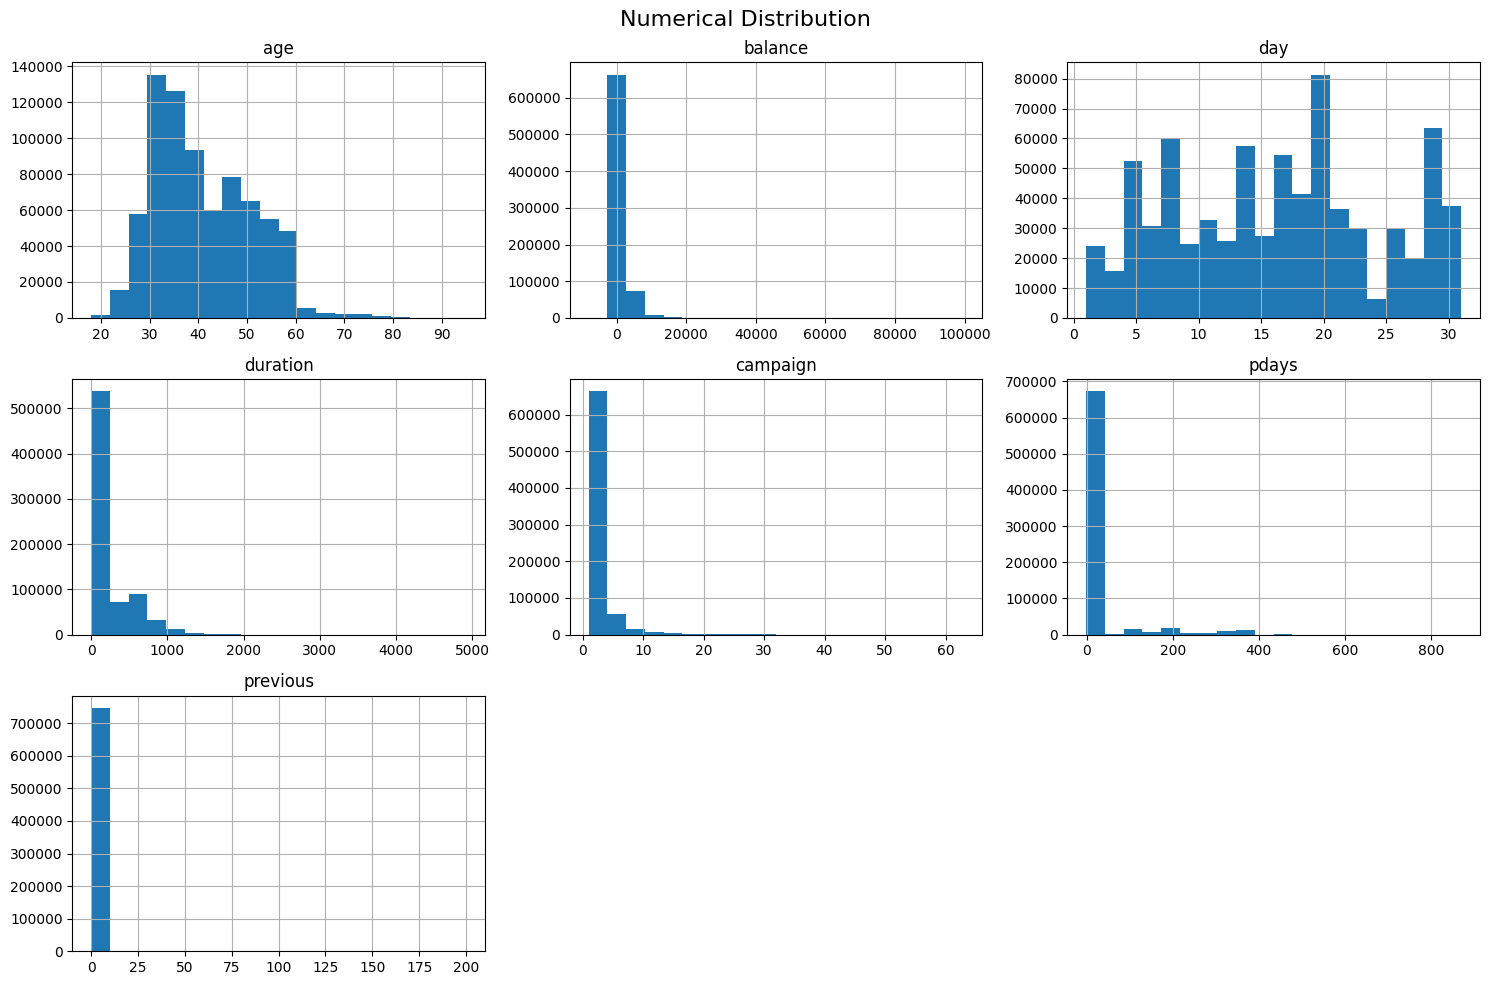

In [10]:
# Visualized the distribution of numerical features in the training set
bank[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Numerical Distribution", fontsize=16)
plt.tight_layout()
plt.show()

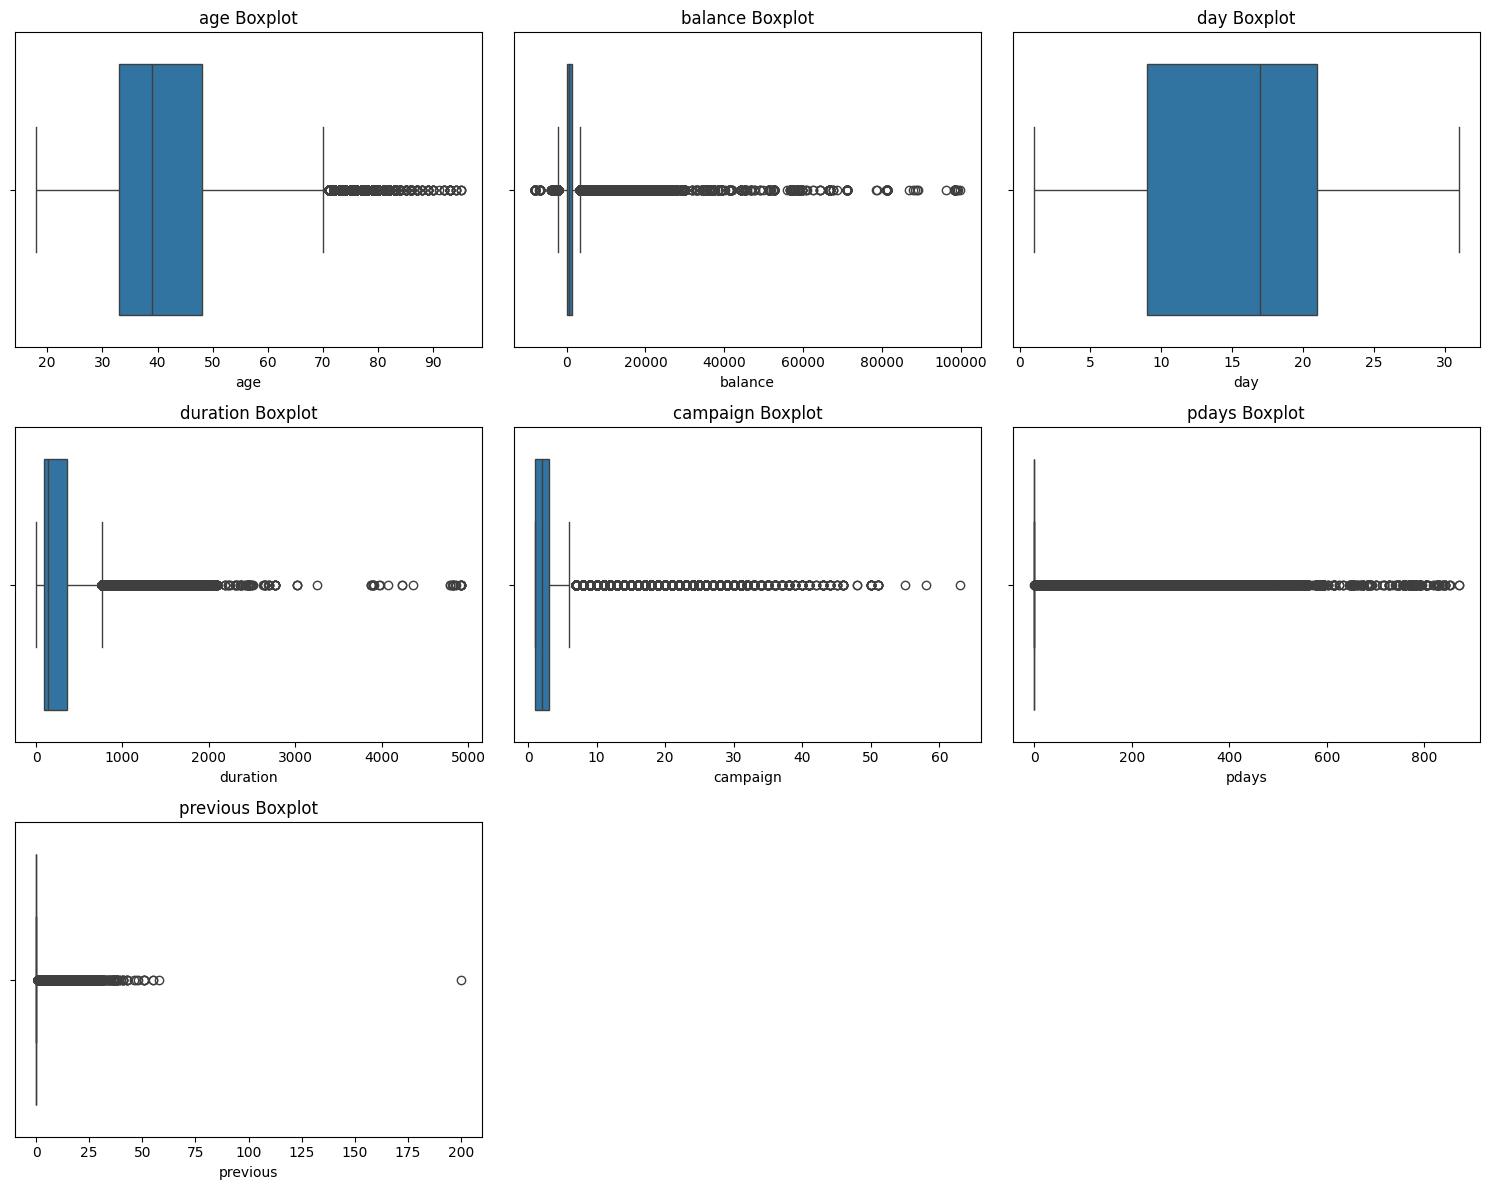

In [11]:
# Checked for outliers in numerical features
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=bank[col], ax=axes[i])
    axes[i].set_title(f'{col} Boxplot')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

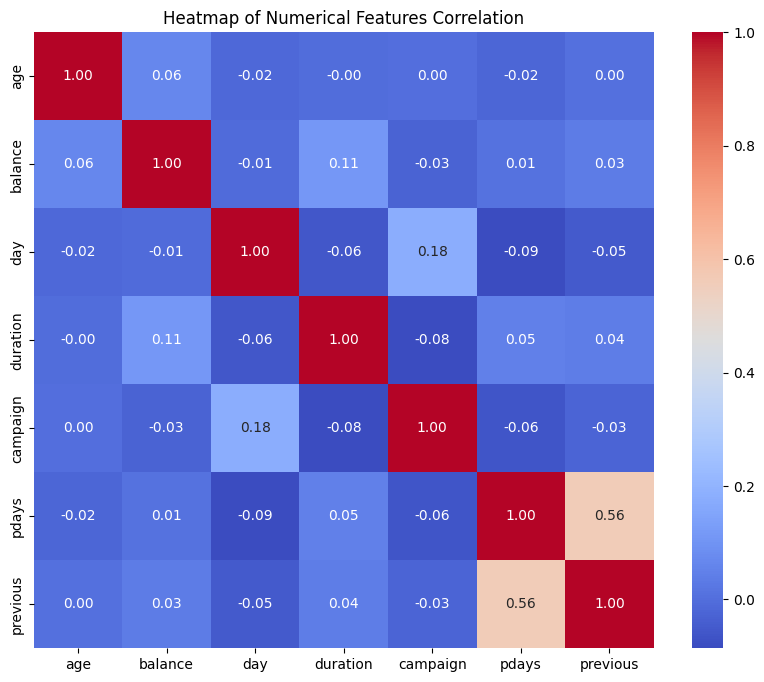

In [12]:
# Checked heatmap of numerical features correlation
plt.figure(figsize=(10, 8))
sns.heatmap(bank[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Numerical Features Correlation")
plt.show()

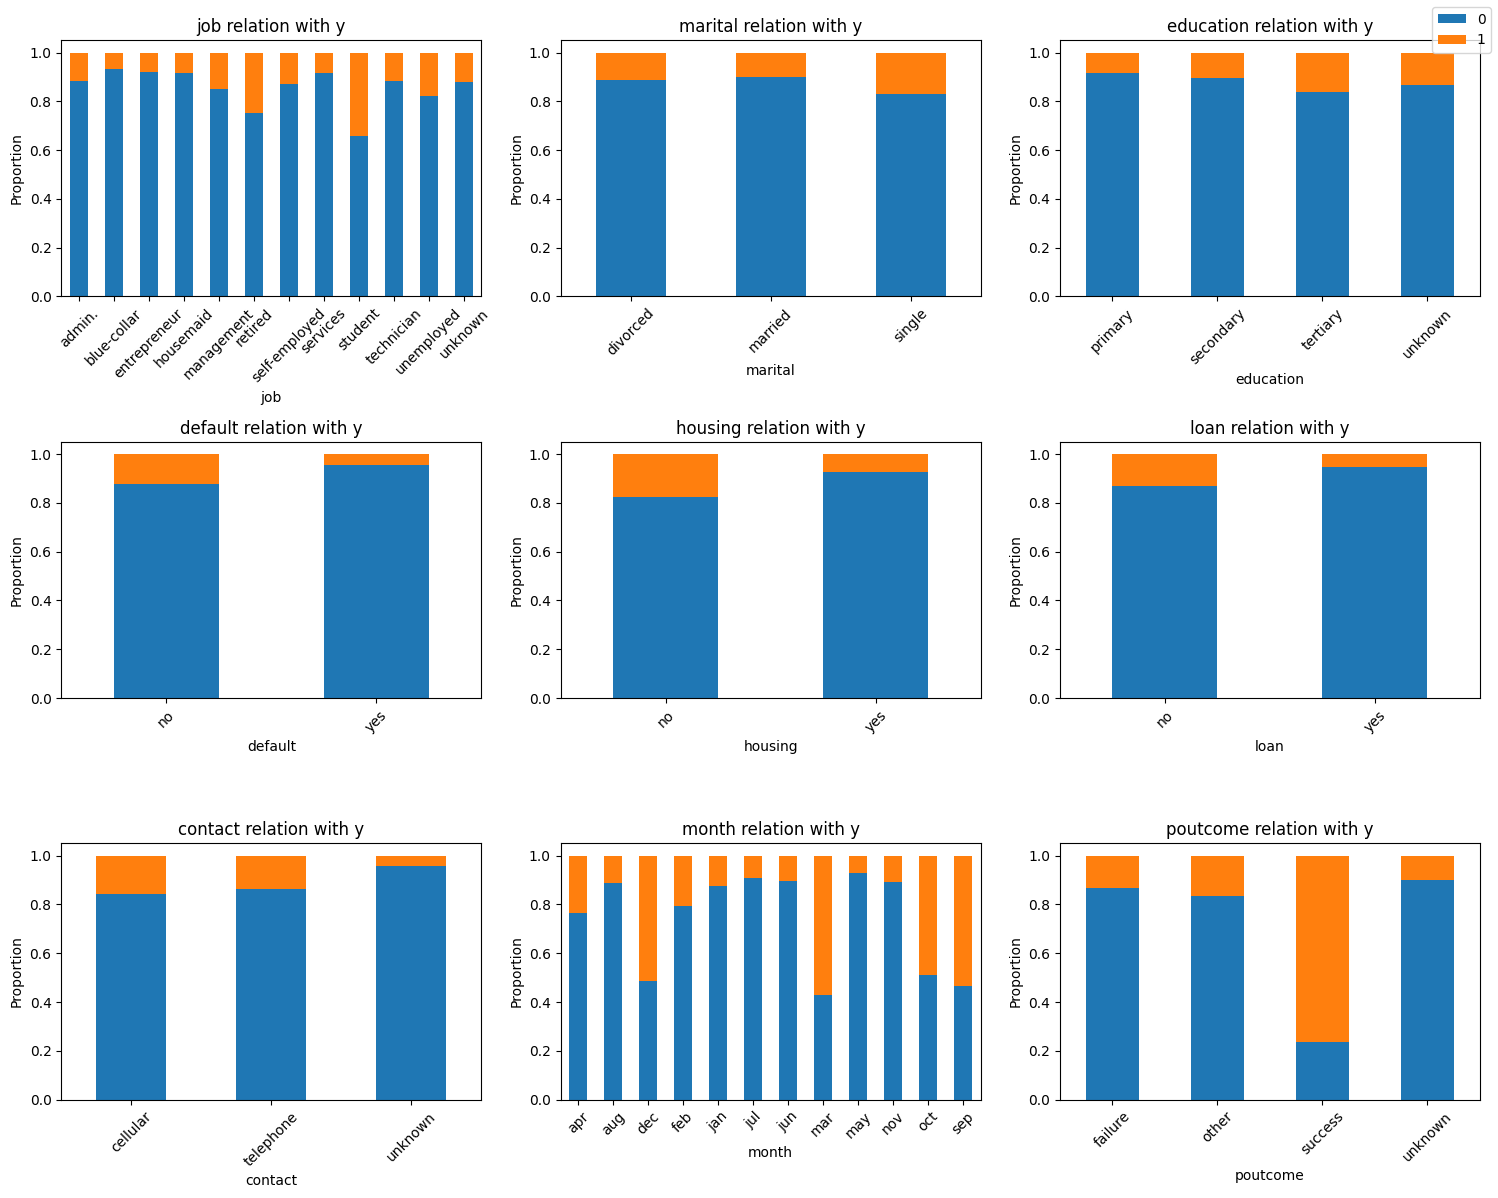

In [13]:
# Checked the relationship between categorical features and the target variable 'y'
n_cols = 3  
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    crosstab = pd.crosstab(bank[col], bank['y'], normalize='index')
    crosstab.plot(kind='bar', stacked=True, ax=axes[i], legend=False)
    axes[i].set_title(f'{col} relation with y')
    axes[i].set_ylabel('Proportion')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# add a overall legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

### Modeling

#### Pre

In [14]:
X = bank.drop(columns=['y'])
y = bank['y']

In [15]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [16]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

In [17]:
# Identity mapping for numeric features and one-hot encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

Logistic: deal with unbalance. 

In [18]:
# Create a pipeline that combines the preprocessor with a logistic regression model
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, class_weight='balanced', random_state=42))
])

log_reg.fit(X_train, y_train)

c:\Users\Yijia Wang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=42))])

In [19]:
# Predict on the validation set
y_pred = log_reg.predict(X_val)
y_proba = log_reg.predict_proba(X_val)[:, 1]

# Evaluate the model
auc_score = roc_auc_score(y_val, y_proba)
report = classification_report(y_val, y_pred, digits=4)
print(auc_score)
print(report)

0.9381002359757347
              precision    recall  f1-score   support

           0     0.9794    0.8680    0.9203    131902
           1     0.4740    0.8670    0.6129     18098

    accuracy                         0.8679    150000
   macro avg     0.7267    0.8675    0.7666    150000
weighted avg     0.9184    0.8679    0.8832    150000



Summary of Logistic:

By the report, we can see who predicted as subscribe, only 47% actually subscribed, there is a lot false positive; for all customer who subscribed, 87% of them being found. This model is not very useful if want to save resource, but okay despite cost to find all potential customers. 


macro avg give equal importance to both 1 and 0, while weighted avg gives more weight to major class which is 0. Thus we have higher accuracy when it is weighted avg, this accuracy might not be very useful since we care more about who actual subscribed.

Tree based model

Since it's tree based model now, let's change categorical encoding from one-hot to ordinal to save time

In [20]:
# Preprocessor: passthrough numeric, OrdinalEncode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ]
)

Random Forest

In [21]:
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        n_jobs=-1,
        random_state=42,
        class_weight='balanced_subsample'
    ))
])
rf_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [22]:
rf_pipe.fit(X_train, y_train)
rf_proba = rf_pipe.predict_proba(X_val)[:, 1]
rf_pred = (rf_proba >= 0.7).astype(int)
rf_auc = roc_auc_score(y_val, rf_proba)
rf_report = classification_report(y_val, rf_pred, digits=4)
print(rf_auc)
print(rf_report)

0.9630218192746699
              precision    recall  f1-score   support

           0     0.9225    0.9912    0.9557    131902
           1     0.8604    0.3934    0.5399     18098

    accuracy                         0.9191    150000
   macro avg     0.8915    0.6923    0.7478    150000
weighted avg     0.9150    0.9191    0.9055    150000



XGBoost

In [23]:
# Handling class imbalance for XGBoost using scale_pos_weight
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / max(pos, 1)

xgb = XGBClassifier(
    n_estimators=500,           
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="auc",          
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",         
    n_jobs=-1,
    random_state=42
)

xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb)
])
xgb_pipe


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('model',
                 XGBClassifier(base_score=...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=500, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [24]:
# Train the XGBoost model
xgb_pipe.fit(X_train, y_train)

y_proba = xgb_pipe.predict_proba(X_val)[:, 1]
y_pred = (y_proba >= 0.7).astype(int)

# Evaluate the model
auc = roc_auc_score(y_val, y_proba)
report = classification_report(y_val, y_pred, digits=4)

print("AUC:", auc)
print(report)

AUC: 0.9670987178620084
              precision    recall  f1-score   support

           0     0.9783    0.9334    0.9553    131902
           1     0.6364    0.8490    0.7275     18098

    accuracy                         0.9232    150000
   macro avg     0.8073    0.8912    0.8414    150000
weighted avg     0.9370    0.9232    0.9278    150000



Light GBM

In [25]:
lgbm_pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', LGBMClassifier(
        n_estimators=500, max_depth=-1, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        objective='binary', random_state=42, n_jobs=-1
    ))
])

lgbm_pipe

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('model',
                 LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05,
                                n_estimators=500, n_jobs=-1, objective='binary',
                                random_state=42, subsample=0.8))])

In [26]:
lgbm_pipe.fit(X_train, y_train)

y_proba = lgbm_pipe.predict_proba(X_val)[:, 1]
y_pred = (y_proba >= 0.7).astype(int)

# Evaluate the model
auc = roc_auc_score(y_val, y_proba)
report = classification_report(y_val, y_pred, digits=4)

print("AUC:", auc)
print(report)

[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120650 -> initscore=-1.986289
[LightGBM] [Info] Start training from score -1.986289
AUC: 0.9671771327198804
              precision    recall  f1-score   support

           0     0.9307    0.9891    0.9590    131902
           1     0.8535    0.4634    0.6007     18098

    accuracy                         0.9257    150000
   macro avg     0.8921    0.7262    0.7798    150000
weighted avg     0.9214    0.9257    0.9158    150000



Summary of Tree Based

Both random forest and XGBoost have AUC around 96-97%.

Since from the logistic model before, I get the idea that I care a little more about predicted as 1 will actual subscribe. Thus I increased the threshold to 0.7. 

The random forest model has high precision around 86%, but the recall is just 34% which we missed too much potential customers. The Light GBM is the similar situation which it has 85% precision and 46% of recall. The XGBoost model has lower precision model around 64% but relatively ok, the recall is 85%. From the business purpose, I think XGBoost is more helpful. 

### Saving

I will save xgb and lgbm for future use

In [27]:
def convert_json(o):
    if isinstance(o, (np.integer,)):  # np.int64, np.int32
        return int(o)
    if isinstance(o, (np.floating,)): # np.float64
        return float(o)
    if isinstance(o, (np.ndarray,)):  # transform to list
        return o.tolist()
    raise TypeError(f"Object of type {type(o)} is not JSON serializable")

In [28]:
from joblib import dump
import json, sys, sklearn, lightgbm, xgboost
import numpy as np
from datetime import datetime

# right now I used 0.7 as the threshold
chosen_threshold = 0.7

# save the whole pipeline (including preprocessing and model)
dump(lgbm_pipe, "lgbm_pipe.joblib")

# 2) save meta information (for future reproduction/tuning)
meta = {
    "saved_at": datetime.now().isoformat(timespec="seconds"),
    "target_name": "y",
    "threshold": chosen_threshold,       # right now I used the threshold
    "feature_columns": list(X_train.columns),
    "class_order": list(getattr(lgbm_pipe.named_steps["model"], "classes_", [0,1])),
    "lgbm_params": lgbm_pipe.named_steps["model"].get_params(),
    "versions": {
        "python": sys.version.split()[0],
        "sklearn": sklearn.__version__,
        "lightgbm": lightgbm.__version__
    }
}
with open("lgbm_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2, default=convert_json)
print("Saved: lgbm_pipe.joblib, lgbm_meta.json")

Saved: lgbm_pipe.joblib, lgbm_meta.json


In [29]:
dump(xgb_pipe, "xgb_pipe.joblib")

meta = {
    "saved_at": datetime.now().isoformat(timespec="seconds"),
    "threshold": float(chosen_threshold),
    "params": xgb.get_params(),                    # 方便以后回看
    "versions": {"python": sys.version.split()[0],
                 "sklearn": sklearn.__version__,
                 "xgboost": xgboost.__version__}
}
with open("xgb_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2, default=convert_json)
print("Saved: xgb_pipe.joblib, xgb_meta.json")

Saved: xgb_pipe.joblib, xgb_meta.json


### Predict

In [30]:
test = pd.read_csv('test.csv')
test.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [31]:
X_test = test.drop(columns=['id'])

In [32]:
test_proba = lgbm_pipe.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.7).astype(int)

# #Save the file
# import pandas as pd
# pd.DataFrame({
#     "id": test["id"],       
#     "prediction": test_pred
# }).to_csv("lgbm_predictions.csv", index=False)